<a href="https://colab.research.google.com/github/yannasyr/landcover/blob/main/yann_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
!pip install timm
!pip install transformers

In [50]:
import os
import random
from timeit import default_timer as timer
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomVerticalFlip,
    RandomHorizontalFlip,
    Normalize,
    RandomRotation,
    ToPILImage,
)

from tifffile import TiffFile, TiffWriter
from sklearn.model_selection import train_test_split
from transformers import SegformerModel, SegformerConfig, AutoImageProcessor, SegformerForSemanticSegmentation

# Utils from the github project

In [5]:
class LandCoverData():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [6]:
def numpy_parse_image_mask(image_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path : path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    # image_path = Path(image_path)
    # get mask path from image path:
    # image should be in a images/<image_id>.tif subfolder, while the mask is at masks/<image_id>.tif
    mask_path = image_path.replace("images","masks")
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        # mask = mask[..., None]
    return image, mask


# Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class LandscapeData(Dataset):

    N_CHANNELS = LandCoverData.N_CHANNELS
    IMG_SIZE = LandCoverData.IMG_SIZE
    TRAIN_PIXELS_MAX = LandCoverData.TRAIN_PIXELS_MAX

    def __init__(self, data_folder, transform=ToTensor()):
        self.data_folder = data_folder
        self.transform = transform

        # Liste des noms de fichiers dans les dossiers
        image_files = os.listdir(os.path.join(data_folder, 'images'))

        # Séparation des données en ensembles d'entraînement, de validation et de test
        train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

        # Utilisez numpy_parse_image_mask pour charger les images et les masques
        self.train_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in train_files]
        self.val_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in val_files]
        self.test_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in test_files]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        image, label = self.train_data[idx]
        channels, height, width = self.N_CHANNELS, self.IMG_SIZE, self.IMG_SIZE

        # Normalisez les valeurs des pixels dans la plage [0, 1]
        image = image.astype("float32") / self.TRAIN_PIXELS_MAX
        label = label.astype("int64")

        image = self.transform(image)

        # Modifiez la transformation pour le masque
        label = torch.tensor(label, dtype=torch.int64)  # Convertir en torch.Tensor
        label = label.squeeze()  # Supprimer la dimension ajoutée

        return image, label


# Exemple d'utilisation
data_folder = "D:/my_git/landscape_data/dataset/small_dataset/"
dataset = LandscapeData(data_folder, transform=transforms.Compose([transforms.ToTensor()]))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


images, masks = next(iter(train_loader))
print("Image : ", images.shape)
print("masks : ", masks.shape)

Image :  torch.Size([4, 4, 256, 256])
masks :  torch.Size([4, 256, 256])


In [12]:
config = SegformerConfig(
    num_labels=10,
    num_channels=4,
)
model = SegformerForSemanticSegmentation(config)

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(5):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for inputs, targets in train_loader:
        # get the inputs;
        pixel_values = inputs.to(device)
        labels = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


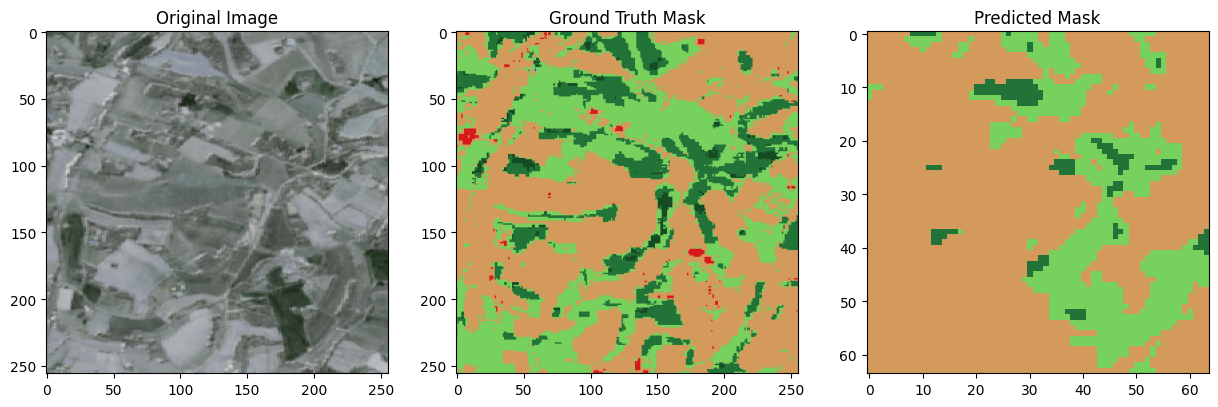

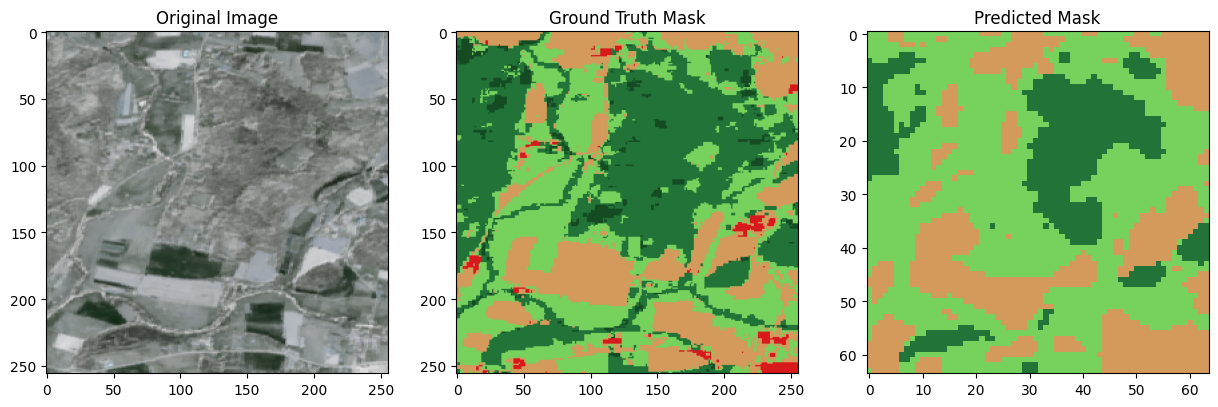

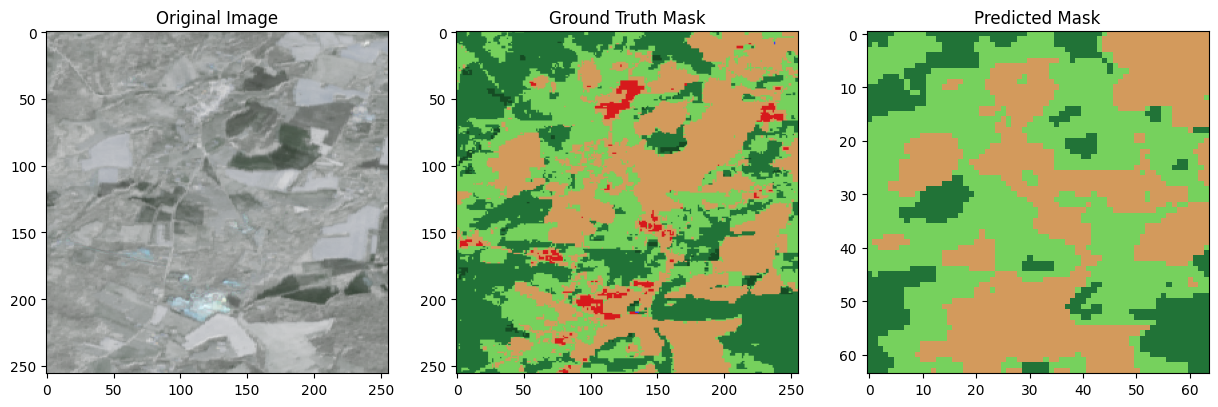

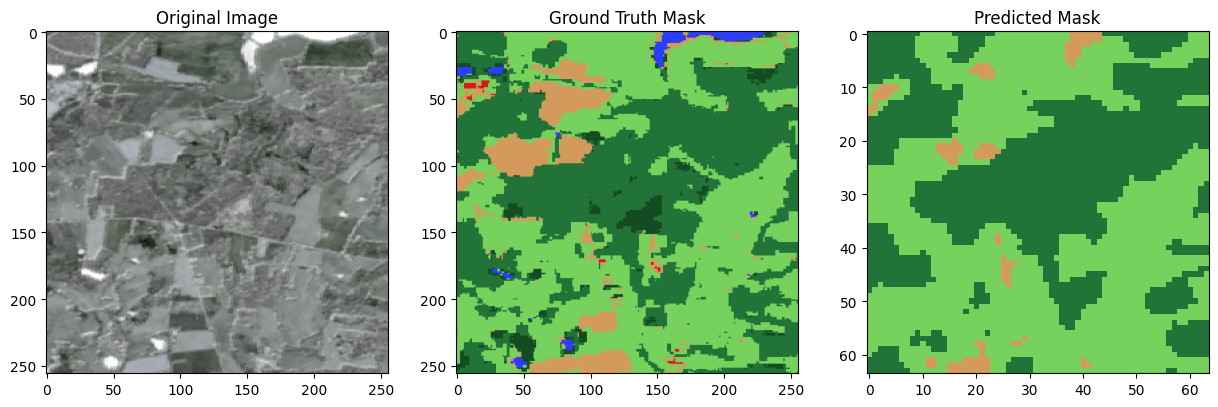

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Color palette
CLASSES_COLORPALETTE = {
    0: [0, 0, 0],
    1: [255, 25, 236],
    2: [215, 25, 28],
    3: [211, 154, 92],
    4: [33, 115, 55],
    5: [21, 75, 35],
    6: [118, 209, 93],
    7: [130, 130, 130],
    8: [255, 255, 255],
    9: [43, 61, 255]
}

# Assuming val_loader is defined in your code
val_inputs, val_targets = next(iter(val_loader))

val_pixel_values = val_inputs.to(device)

# Set the model to evaluation mode
model.eval()
# Perform inference on the validation image
with torch.no_grad():
    val_outputs = model(pixel_values=val_pixel_values)
    val_logits = val_outputs.logits

# Convert logits to predicted labels
_, predicted_labels = torch.max(val_logits, dim=1)

# Visualize the results for one image
for i in range(4):  # Assuming batch size is 4
    plt.figure(figsize=(15, 5))

    # Original image
    original_image = val_inputs[i].permute(1, 2, 0).cpu().numpy()
    original_image = original_image / original_image.max()  # Normalize to [0, 1]
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    ground_truth_mask = val_targets[i].cpu().numpy()
    ground_truth_mask_rgb = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASSES_COLORPALETTE.items():
        ground_truth_mask_rgb[ground_truth_mask == cls] = color
    plt.imshow(ground_truth_mask_rgb)
    plt.title("Ground Truth Mask")

    # Predicted mask
    plt.subplot(1, 3, 3)
    predicted_mask = predicted_labels[i].cpu().numpy()
    predicted_mask_rgb = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASSES_COLORPALETTE.items():
        predicted_mask_rgb[predicted_mask == cls] = color
    plt.imshow(predicted_mask_rgb)
    plt.title("Predicted Mask")

    plt.show()

In [5]:
# Estimation du vecteur Y = [no_data, clouds, artificial, cultivated, broadleaf, coniferous, herbaceous, natural, snow, water]
def get_Y(mask2d):
  """
  Estimation du vecteur contenant les proportions de chaque classe dans une image segmentée:
  Y = [no_data, clouds, artificial, cultivated, broadleaf, coniferous, herbaceous, natural, snow, water]
  """
  occurrences = np.bincount(mask2d.flatten(), minlength=10)
  Y = occurrences / np.sum(occurrences)
  return Y

def klmetric(y_t, y_p, eps):
  """
  Calcul de la divergence de Kullbach-Leiber
  Args:
    - y_t (np.array) : Le vecteur Ground Truth.
    - y_p (np.array) : Le vecteur des prédictions.
    - eps : epsilon dans la formule de K-L divergence.
  """
  sum = 0
  for i in range(len(y_t)):
    sum += (y_t[i]+eps)*np.log((y_t[i] + eps) / (y_p[i] + eps))
  return sum

In [6]:
def mesure_on_batch(batch_gt, batch_predi, batch_size=4):
  mean = 0
  for i in range(batch_size):
    Y_pred = get_Y(batch_gt[i].cpu().numpy())
    Y_truth = get_Y(batch_predi[i].cpu().numpy())
    mean += klmetric(Y_truth, Y_pred, 10e-8)
  return mean / batch_size

def mesure_on_dataloader(test_dataloader):
  """Implémentation de la mesure 'Kullbach-Leiber divergence'
  Args:
      test_dataloader (Dataloader): Le dataloader contenant le dataset de test.
  Returns:
      (float32): La valeur de KL-divergence.
  """
  mean = 0
  for i in range(len(test_dataloader)):
    test_inputs, test_targets = next(iter(val_loader))
    test_pixels_values = test_inputs.to(device)
    model.eval()
    with torch.no_grad():
      test_outputs = model(pixel_values=test_pixels_values)
      test_logits = test_outputs.logits

    _, predicted_labels = torch.max(test_logits, dim=1)

    mean += mesure_on_batch(test_targets, predicted_labels)

  return mean / len(test_dataloader)

In [16]:
kl = mesure_on_dataloader(val_loader)
print(f"Kullback–Leibler divergence on this dataset : {kl:.4f}")

Kullback–Leibler divergence on this dataset : 0.1196


# Essayons de rebalancer les classes

On va utiliser la fonction ```get_Y``` sur tous les masques de la base de train.

In [13]:
# Dossier contenant les masques de segmentation ()
dossier_masks = 'D:/my_git/landscape_data/dataset/train/masks/'

# On va stocker les valeurs Y dans une liste
stock_Y_train_mask = []

for mask in os.listdir(dossier_masks):
    chemin_mask = os.path.join(dossier_masks, mask)

    with TiffFile(chemin_mask) as tifm:
        mask = tifm.asarray()
        
    stock_Y_train_mask.append(get_Y(mask))

print(len(stock_Y_train_mask))

18491


In [20]:
# Pour des questions de vitesse et de fonctions dispo, on passe en np.array
data_array = np.array(stock_Y_train_mask)

mean_values = np.mean(data_array, axis=0)
median_values = np.median(data_array, axis=0)
q1_values = np.percentile(data_array, 25, axis=0)
q3_values = np.percentile(data_array, 75, axis=0)
max_values = np.max(data_array, axis=0)

classes = ['no_data', 'clouds', 'artificial', 'cultivated', 'broadleaf', 'coniferous', 'herbaceous', 'natural', 'snow', 'water']

for i, classe in enumerate(classes):
    print(f"Classe : {classe}")
    print(f"  Médiane : {median_values[i]}")
    print(f"  Q1 : {q1_values[i]}")
    print(f"  Q3 : {q3_values[i]}")
    print(f"  max : {max_values[i]}")

Classe : no_data
  Médiane : 0.0
  Q1 : 0.0
  Q3 : 0.0
  max : 0.0
Classe : clouds
  Médiane : 0.0
  Q1 : 0.0
  Q3 : 0.0
  max : 0.006072998046875
Classe : artificial
  Médiane : 0.0157928466796875
  Q1 : 0.00443267822265625
  Q3 : 0.0519561767578125
  max : 0.87493896484375
Classe : cultivated
  Médiane : 0.295501708984375
  Q1 : 0.11100006103515625
  Q3 : 0.5278701782226562
  max : 0.99249267578125
Classe : broadleaf
  Médiane : 0.176300048828125
  Q1 : 0.06214141845703125
  Q3 : 0.35565185546875
  max : 0.9886016845703125
Classe : coniferous
  Médiane : 0.0261688232421875
  Q1 : 0.0059967041015625
  Q3 : 0.09979248046875
  max : 0.99676513671875
Classe : herbaceous
  Médiane : 0.2410888671875
  Q1 : 0.1411895751953125
  Q3 : 0.3711395263671875
  max : 0.99969482421875
Classe : natural
  Médiane : 0.0
  Q1 : 0.0
  Q3 : 0.0002593994140625
  max : 0.868438720703125
Classe : snow
  Médiane : 0.0
  Q1 : 0.0
  Q3 : 0.0
  max : 0.004852294921875
Classe : water
  Médiane : 0.000152587890625

In [42]:
classe_interet = "artificial"

# Indice de la classe dans la liste. 
indice_classe = classes.index(classe_interet)

# Taux de pourcentage minimum de cette classe dans l'image
seuil = 0.3
indices_images_sup_seuil = np.where(data_array[:, indice_classe] > seuil)[0]

print(f"Nombre d'images avec une proportion de {classe_interet} supérieure à {seuil}: {len(indices_images_sup_seuil)}")


Nombre d'images avec une proportion de artificial supérieure à 0.3: 557


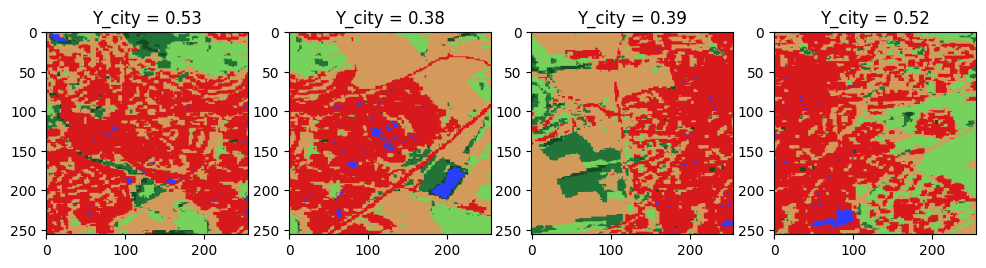

In [44]:
CLASSES_COLORPALETTE = {
    0: [0, 0, 0],
    1: [255, 25, 236],
    2: [215, 25, 28],
    3: [211, 154, 92],
    4: [33, 115, 55],
    5: [21, 75, 35],
    6: [118, 209, 93],
    7: [130, 130, 130],
    8: [255, 255, 255],
    9: [43, 61, 255]
}

compteur = 0
compteur_a_passer = 0
compteur_plot = 1

plt.figure(figsize=(12,5))

for mask in os.listdir(dossier_masks):
    if compteur in indices_images_sup_seuil:
        if compteur_a_passer > 8:
            if compteur_plot <= 4:
                chemin_mask = os.path.join(dossier_masks, mask)

                with TiffFile(chemin_mask) as tifm:
                    mask = tifm.asarray()
                    
                mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
                for cls, color in CLASSES_COLORPALETTE.items():
                    mask_rgb[mask == cls] = color
                plt.subplot(1,4,compteur_plot), plt.imshow(mask_rgb), plt.title(f'Y_city = {stock_Y_train_mask[compteur][2]:.2f}')
                compteur_plot += 1
        compteur_a_passer += 1
    compteur += 1

plt.show()

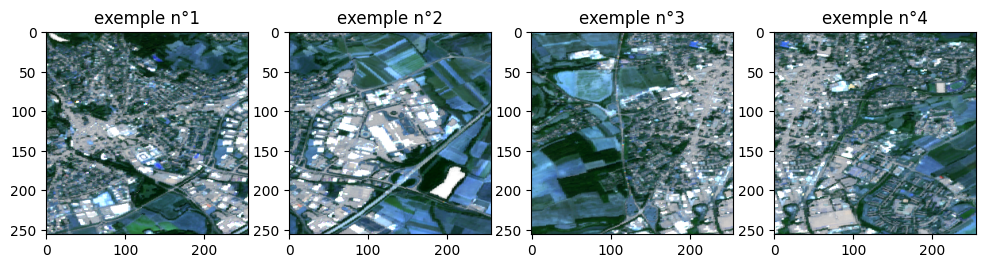

In [45]:
dossier_images = 'D:/my_git/landscape_data/dataset/train/images/'

plt.figure(figsize=(12,5))

compteur = 0
compteur_a_passer = 0
compteur_plot = 1

for image in os.listdir(dossier_images):
    if compteur in indices_images_sup_seuil:
        if compteur_a_passer > 8:
            if compteur_plot <= 4:
                chemin_image = os.path.join(dossier_images, image)

                with TiffFile(chemin_image) as tifm:
                    image = tifm.asarray()
                    iscale = 2200 - 0
                    scale = 255 / iscale
                    byte_im = (image) * scale
                    byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
                    image = byte_im

                plt.subplot(1,4,compteur_plot), plt.imshow(image), plt.title(f'exemple n°{compteur_plot}')
                compteur_plot += 1
        compteur_a_passer += 1
    compteur += 1

plt.show()

Maintenant, faisons un joli code qui fait tout de manière automatique. On va commencer par ré-équilibrer les classes ```artificial``` et ```water```. 

Pour ça, on va d'abord 
- déplacer les images et masques avec $artificial\% > 0.3$ dans un dossier ```train_augmented```.
- déplacer les images et masques avec $water\% > 0.3$ dans un dossier ```train_augmented```.
- faire de la Data-Augmentation sur ces images.
- importer le reste des images depuis le dossier ```train```

In [90]:
import shutil

# Dossier contenant les masques de segmentation ()
dossier_train = 'D:/my_git/landscape_data/dataset/small_dataset_bis/'
dossier_augmented = 'D:/my_git/landscape_data/dataset/small_dataset_bis_augmented/'
dossier_images = dossier_train + 'images/'
dossier_masks = dossier_train + 'masks/'

# Si le dossier "augmented" n'existe pas, on le créé. 
if not os.path.exists(dossier_augmented):
    os.makedirs(dossier_augmented)
    print(f"Le dossier {dossier_augmented} a été créé avec succès.")

seuil_per_water = 0.3
seuil_per_city = 0.3

# Déplacement des images intéressantes.
for mask_filename in os.listdir(dossier_masks):
    chemin_mask = os.path.join(dossier_masks, mask_filename)
    chemin_image = os.path.join(dossier_images, mask_filename)

    with TiffFile(chemin_mask) as tifm:
        mask = tifm.asarray()
        
    Y = get_Y(mask) # Y[2] = 'artificial' and Y[9] = 'water'

    if Y[2] > seuil_per_city or Y[9] > seuil_per_water:
        destination_mask = os.path.join(dossier_augmented, 'masks', mask_filename)
        destination_image = os.path.join(dossier_augmented, 'images', mask_filename)

        os.makedirs(os.path.dirname(destination_mask), exist_ok=True)
        os.makedirs(os.path.dirname(destination_image), exist_ok=True)

        shutil.copy(chemin_mask, destination_mask)
        shutil.copy(chemin_image, destination_image)

Le dossier D:/my_git/landscape_data/dataset/small_dataset_bis_augmented/ a été créé avec succès.


On va utiliser quatre fonctions pour la data-augmentation.

In [91]:
import cv2

def enhanceimage(image_path, mask_path):

    enhanced_images = []
    enhanced_masks = []

    with TiffFile(image_path) as img:
        image = img.asarray()

    with TiffFile(mask_path) as msk:
        mask = msk.asarray()

    #Randomly adjust brightness
    value = random.randint(-3000, 3000)
    brightness_image = adjust_brightness(image, value)
    enhanced_images.append(brightness_image)
    enhanced_masks.append(mask)

    #Rotate the image by 90 degrees
    rotate_image = rotate_image_90(image)
    rotate_mask = np.rot90(mask)
    enhanced_images.append(rotate_image)
    enhanced_masks.append(rotate_mask)

    # Flip the image horizont:ally
    flip_image = flip_image_horizontally(image)
    flip_mask = cv2.flip(mask,1)
    enhanced_images.append(flip_image)
    enhanced_masks.append(flip_mask)
    
    return enhanced_images, enhanced_masks


def adjust_brightness(image, value):
    brightness_images = []
    for channel in range(image.shape[-1]):
        brightness_channel = np.int32(image[:, :, channel])
        brightness_channel = brightness_channel + value
        brightness_channel = np.clip(brightness_channel, 0, 65535)
        brightness_channel = np.uint16(brightness_channel)
        brightness_images.append(brightness_channel)

    return np.stack(brightness_images, axis=-1).astype(np.uint16) 

def rotate_image_90(image):
    rotate_images = []
    for channel in range(image.shape[-1]):
        rotate_channel = np.rot90(image[:, :, channel], k=1)  # Rotate by 90 degrees
        rotate_images.append(rotate_channel)

    rotated_image = np.stack(rotate_images, axis=-1).astype(np.uint16)
    return rotated_image

def flip_image_horizontally(image):
    flip_images = []
    for channel in range(image.shape[-1]):
        flip_channel = cv2.flip(image[:, :, channel], 1)
        flip_images.append(flip_channel)

    return np.stack(flip_images, axis=-1).astype(np.uint16)

In [92]:
dossier_augmented_image = dossier_augmented + 'images/'
dossier_augmented_masks = dossier_augmented + 'masks/'

for image in os.listdir(dossier_augmented_image):
    image_path = os.path.join(dossier_augmented_image, image)
    mask_path = os.path.join(dossier_augmented_masks, image)
    enhanced_images, enhanced_masks = enhanceimage(image_path, mask_path)

    for i, enhanced_image in enumerate(enhanced_images):
        transformed_image_path = os.path.join(dossier_augmented_image, image.replace('.tif', f'_t{i}.tif'))
        transformed_mask_path = os.path.join(dossier_augmented_masks, image.replace('.tif', f'_t{i}.tif'))
        with TiffWriter(transformed_image_path) as tifi:
            tifi.write(enhanced_image)
        with TiffWriter(transformed_mask_path) as tifm:
            tifm.write(enhanced_masks[i])

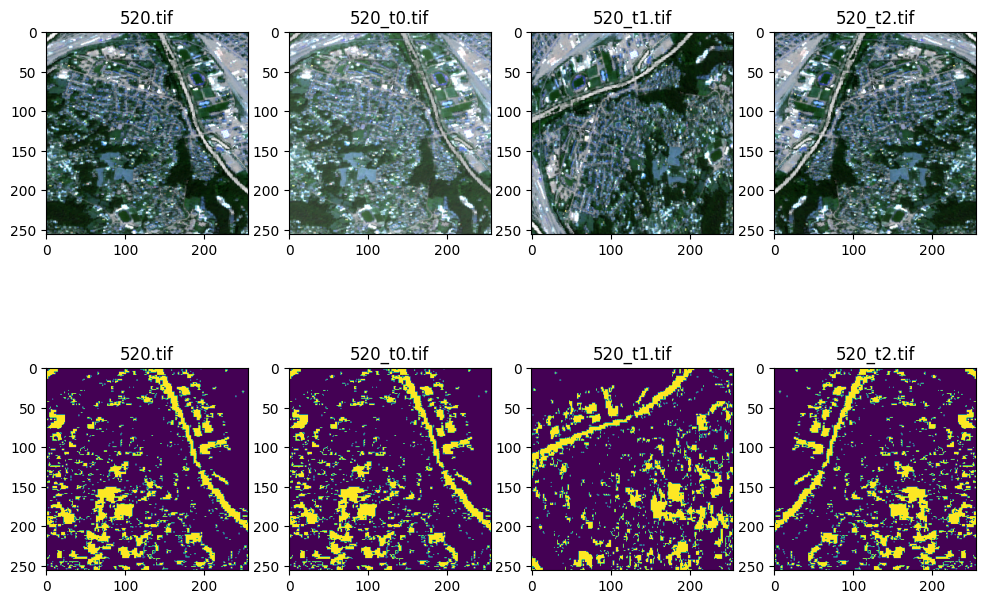

In [96]:
plt.figure(figsize=(12,8))

compteur = 1
for image in os.listdir(dossier_augmented_image):
    if compteur <= 4:
        with TiffFile(os.path.join(dossier_augmented_image, image)) as img:
            im = img.asarray()
            iscale = 2200 - 0
            scale = 255 / iscale
            byte_im = (im) * scale
            byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
            im = byte_im

        plt.subplot(2,4,compteur), plt.imshow(im), plt.title(image)

        with TiffFile(os.path.join(dossier_augmented_masks, image)) as img:
            im = img.asarray()
            iscale = 2200 - 0
            scale = 255 / iscale
            byte_im = (im) * scale
            byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
            im = byte_im

        plt.subplot(2,4,4+compteur), plt.imshow(im), plt.title(image)
        compteur += 1
            
plt.show()
